In [37]:
import os 
import random
import numpy as np
from PIL import Image

from datetime import datetime
import pickle
from tqdm import tqdm #loading bar  

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as ParentDataset

import torchvision
from torchvision import transforms
from torchvision.transforms import Compose

import sklearn.metrics

import segmentation_models_pytorch as smp #model we're using for now. 
import evaluateModel

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [38]:
class TBI_dataset(ParentDataset): #Obtain the attributes of ParentDataset from torch.utils.data
#Finds Image and Label locations, creates random list of indicies for training / val / testing sets to be called
    def __init__(
        self,
        images_dir,
        labels_dir,
        subset="train",
        transform = None, #base transformation is into Tensor. 
        mapping = None #there is no mapping initially. model should stop if no mapping provided. 
        #seed=seed, #We'll get the same thing everytime if we keep using the same seed. 
    ):
        
        #filter and sort the list
        self.ImageIds = sorted(list(filter(('.DS_Store').__ne__,os.listdir(images_dir)))) 
        self.LabelIds = sorted(list(filter(('.DS_Store').__ne__,os.listdir(labels_dir))))
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ImageIds] #full_paths to slices
        self.labels_fps = [os.path.join(labels_dir, image_id) for image_id in self.LabelIds] #full_paths to labels

        if mapping == None:
            print("Mapping Required for Model to Run!")

        #We define a mapping to use when calling the Dataset loader based on the parameter "mapping"
        if subset == "train":
            self.mapping = mapping['train']['set']
            print(self.mapping)
        elif subset == "val":
            self.mapping = mapping['val']['set']
            print(self.mapping)
        elif subset == "test":
            self.mapping = mapping['test']['set']
            print(self.mapping)
        else:
            print("subset parameter requires train, val, or test exactly.")

        self.transform = transform #trasform given by transform_function
            
    def __getitem__(self, ii): #ii is the index
        
        #Current implementations of transforms only use PIL images.
        #Apparently we can use np.array(Image.open(...)) to remove the error that happens each epoch
        image = Image.open(self.images_fps[self.mapping[ii]]) #open as PIL image. 
        label = Image.open(self.labels_fps[self.mapping[ii]])
         
        image = self.transform(image)
        label = self.transform(label)
             
        return image, label #, self.images_fps[self.mapping[ii]],self.labels_fps[self.mapping[ii]]
    
    def __len__(self):
        return len(self.mapping)
    
    
def datasets(images_dir, labels_dir, train_size, aug_angle, aug_scale, flip_prob):
    
    mapping = return_image_indicies(images_dir,labels_dir, train_size, random_sampling = True)
    
    train = TBI_dataset(
        images_dir = images_dir,
        labels_dir = labels_dir,
        subset = "train",
        transform = transform_function(degrees=aug_angle, scale=aug_scale, flip_prob=flip_prob),
        mapping = mapping
    )
    valid = TBI_dataset(
        images_dir = images_dir,
        labels_dir = labels_dir,
        subset = "val",
        transform = transform_function(degrees=aug_angle, scale=aug_scale, flip_prob=flip_prob),
        mapping = mapping
    )
    
    test = TBI_dataset(
        images_dir = images_dir,
        labels_dir = labels_dir,
        subset= "test",
        transform = transform_function(degrees=0, scale = [1,1], flip_prob = 0), #make sure nothing changes. 
        mapping = mapping
    )
    
    return train, valid, test

def return_image_indicies(images_dir, labels_dir, train_size, random_sampling = True):
    #This function returns a dictionary of indicies that correspond to images in the dataset. 
    #Separate function and called ONCE to ensure that multiple sets are not being created. 
    
    #filter and sort the list
    ImageIds = sorted(list(filter(('.DS_Store').__ne__,os.listdir(images_dir)))) 
    LabelIds = sorted(list(filter(('.DS_Store').__ne__,os.listdir(labels_dir))))

    images_fps = [os.path.join(images_dir, image_id) for image_id in ImageIds] #full_paths to slices
    labels_fps = [os.path.join(labels_dir, image_id) for image_id in LabelIds] #full_paths to labels

    if random_sampling == True:
        samples = list(range(0,len(images_fps))) #create a list of numbers
        #random.seed(seed) #set the seed

        #random sample train_size amount and then do a train/validation split 
        indicies = random.sample(samples,round(train_size*len(samples)))
        val_indicies = indicies[0:round(len(indicies)*0.15)] #15% of the dataset goes towards validation.
        train_indicies = indicies[round(len(indicies)*0.15) : len(indicies)]

        test_indicies = samples
        for j in sorted(indicies, reverse = True): #remove the train/val indicies from test set
            del test_indicies[j]

        #suffles without replacement. 
        test_indicies = random.sample(test_indicies, len(test_indicies)) 
    
    mapping = {}
    mapping['train'] = { 'set' : train_indicies}
    mapping['val'] = { 'set' : val_indicies}
    mapping['test'] = { 'set' : test_indicies}
    
    return mapping

def transform_function(degrees,scale,flip_prob):
    transform_list = []
    
    transform_list.append(transforms.RandomAffine(degrees, scale = scale))
    transform_list.append(transforms.RandomHorizontalFlip(p=flip_prob))
    transform_list.append(transforms.Pad(37)) #all images should be 182x182 before padding. 
    transform_list.append(transforms.ToTensor())
    
    return Compose(transform_list)

def Weights(labels, device):
    #expects an [batch_size,c,n,n] input 
    
    weights = torch.rand(labels.shape) #create a random tensor of weight values. 
    weights = weights.to(device) #put everything onto the GPU. 
    
    for batch_num in range(0,labels.shape[0]):
        num_ones = torch.sum(labels[batch_num,0,:,:]);
        resolution = labels.shape[2] * labels.shape[3]
        num_zeros = resolution - num_ones 
        
        #https://discuss.pytorch.org/t/how-to-apply-a-weighted-bce-loss-to-an-imbalanced-dataset-what-will-the-weight-tensor-contain/56823/2
        #Weight for the positive class
        pos_weight = num_zeros / resolution #should be close to 1.
        neg_weight = 1 - pos_weight 
        
        #create 1s tensor, put to GPU.
        ones = torch.ones(labels.shape[2],labels.shape[3])
        ones = ones.to(device)
        
        weights[batch_num,0,:,:] = ones*neg_weight + labels[batch_num,0,:,:]*pos_weight
        
    #this keeps the clas imbalance in check
    return weights,pos_weight,neg_weight #should be a tensor. 

In [39]:
#This function expects singular images. 
#Also biased from high class imbalance. function currently not in use. 
def IoU(prediction, label):
    #Prediction IoU
    intersection = int(torch.sum(torch.mul(prediction,label)))
    union = int(torch.sum(prediction) + torch.sum(label)) - intersection
    IOU_predicted = intersection / (union + 0.0001) #for stability
    mean_IoU = IOU_predicted
    
    #Not including background IoU
    #Background IoU
    #all_zeros = (prediction + label) > 0 #before the inversion
    #intersection = int(torch.sum(~all_zeros))
    #union = int(torch.sum(~ (prediction > 0)) + torch.sum(~ (label > 0)) - intersection)
    #IOU_background = intersection / (union + 0.0001)
    
    #mean_IOU = (IOU_background + IOU_predicted)/2
    return mean_IoU

In [40]:
def testModel(test_dataset, modelPath, threshold): #model = the model class = smp.UNet()

    total_images = 0
    mean_IoUs = []
    CM_values = [0,0,0,0] #tp, fn, fp, tn
    model.load_state_dict(torch.load(modelPath))
    
    if torch.cuda.is_available():
        dev ="cuda:2"
    else:
        dev = "cpu"
        
    dev = torch.device(dev)
    model.to(dev) 
    model.eval() #evaluation mode to turn off the gradients / training. 
    
    #turn shuffle off 
    loader = DataLoader(test_dataset, batch_size = 12, shuffle = False, num_workers = num_workers)
    for ii, data in tqdm(enumerate(loader)):
        
        brains = data[0]
        labels = data[1]
        
        #move the data to the GPU 
        brains = brains.to(dev)
        labels = labels.to(dev)
        
        total_images += brains.shape[0] #this would be the same if we used labels or predictions. 
        #print(total_images)
        
        predictions, _ = model(brains)
        predictions = torch.sigmoid(predictions) 
        
        predictions_numpy = predictions.cpu().detach().numpy()
        labels_numpy = labels.cpu().detach().numpy()
        for j in range(predictions.shape[0]):
            #labels = [False, True] are needed to make sure we don't have errors with the shape of CM
            #mean_IoUs.append(IoU(predictions[j,0,:,:].cpu() > threshold, labels[j,0,:,:].cpu() > threshold)) #determine the mean IoU
            CM = sklearn.metrics.confusion_matrix(labels_numpy[j,0,:,:].ravel(), predictions_numpy[j,0,:,:].ravel() > threshold, labels = [True,False])
            try: 
                CM_values[0] = CM_values[0] + CM[0][0]
                CM_values[1] = CM_values[1] + CM[0][1]
                CM_values[2] = CM_values[2] + CM[1][0]
                CM_values[3] = CM_values[3] + CM[1][1]
            except:
                print("Error in Appending")
                return CM, CM_values
            
    del loader #delete loader, might be wrong to do this
    return np.divide(CM_values , (total_images*(256*256))) #, np.divide(np.sum(mean_IoUs), len(mean_IoUs))



In [245]:
#load in the directory names of models and test results
base = '/home/mccrinbc'
model_names = [#'results_TBI_model-End-2020-11-04-14-18',
#'results_TBI_model-End-2020-11-04-14-34',
#'results_TBI_model-End-2020-11-04-14-49',
#'results_TBI_model-End-2020-11-04-15-5',
#'results_TBI_model-End-2020-11-04-15-20',
'results_TBI_model-End-2020-11-04-15-36',
'results_TBI_model-End-2020-11-04-15-51',
#'results_TBI_model-End-2020-11-04-16-6',
'results_TBI_model-End-2020-11-05-10-42',
'results_TBI_model-End-2020-11-05-11-18',
'results_TBI_model-End-2020-11-05-11-38']

model_paths = []
pkl_paths = []

for ii, name in enumerate(model_names):
    model_paths.append(os.path.join(base, name, name + '.pt')) #state dictionaries
    pkl_paths.append(os.path.join(base, name, name + '.pkl'))

In [246]:
num_workers = 1

images_dir = "/home/mccrinbc/Data_Removed_Useless_Slices/normalized_slices"
labels_dir = "/home/mccrinbc/Data_Removed_Useless_Slices/slice_labels"

#ENCODERS = ['resnet101', 'resnet101', 'resnet101','resnet101','resnet101','resnet101','resnet101','resnet101']
ENCODERS = ['resnet101', 'resnet101', 'vgg19','inceptionv4','densenet121']

In [247]:
#smp specific variables
#need encoder and dropout probability from models

#Each model should be exposed to the same training and validation sets, but the training should be stochastic. 
#Before running ensembles, we need to make sure that every model, regardless if trained on the same data, is 
#arriving at slightly different predictions. 

loaders = [] #might not have enough memory to do this
models = []

aux_params=dict(
    pooling='avg',             # one of 'avg', 'max'
    dropout=0.4,               # dropout ratio, default is None
    #activation='softmax2d',   # activation function, default is None. This is the output activation. softmax2d specifies dim = 1 
    classes=1,                 # define number of output labels
)

for ii, ENCODER in enumerate(ENCODERS):
    #These need to be the results correspodning to the model you're loading. 
    with open(pkl_paths[ii],'rb') as f:  
        brains, labels, predictions, single_class, loss_train, loss_valid, epochLoss_train, epochLoss_valid, test_dataset = pickle.load(f)

    loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, num_workers = num_workers)
    loaders.append(loader)
    
    model = smp.Unet(encoder_name = ENCODER, in_channels=1, classes = 1, aux_params = aux_params)
    model.load_state_dict(torch.load(model_paths[ii]))
    model.eval() #put into evaluation mode
    #model.train()
    model.to(torch.device('cpu'))
    
    models.append(model)
    del model

In [248]:
#calculate the variance within a set of tensors. 
def variance(ensemble_set):
    sum_data = torch.zeros(1,1,256,256) #set the variable. 
    means = torch.mean(torch.stack(ensemble_set), dim = 0)
    for ii, data in enumerate(ensemble_set):
        sum_data += (data - means)**2
    variance = sum_data / len(ensemble_set)
    
    #Normalization of variance? 
    #variance = (variance - variance.min().item()) / (variance.max().item() - variance.min().item()) 
    return variance

In [249]:
#shape of brain / labels from datasets are [1,256,256]. 
def compute_ensemble_prediction(loaders, index, models, threshold, eps):
    #Variable number of arguments, expects only images.
    
    ensemble_set = []
    loss_function = torch.nn.BCELoss()
    
    for ii in range(len(loaders)):
        #Data loaded, unsqueeze, pass through prediction machine, output probabilities in Tensor [1,1,256,256]
        brain = loaders[ii].dataset[index][0].unsqueeze(0) #index brain/label, get brain only, compress to only 2D
        label = loaders[ii].dataset[index][1][0]

        brain = Variable(brain, requires_grad=True) #convert tensor into a variable. need this for adverarial. 
        predictions, _ = models[ii](brain)
        predictions = torch.sigmoid(predictions)
        thresh_prediction = predictions > threshold
        
        weights = Weights(labels.to('cpu'),'cpu')
        loss_function.pos_weight = weights  #I'm not sure if weighting these are the best way to go.
        
    ########################################################################################
    #### Creating an adversarial example of the prediction to determine OOD performance ####
    
        weights = Weights(labels.to('cpu'),'cpu')
        loss_function.pos_weight = weights  #I'm not sure if weighting these are the best way to go.

        #predictions.requires_grad = True #will already be True
        loss_value = loss_function(predictions[0,0], label) #obtain the loss. Making sure they're the same shape. 
        loss_value.backward(retain_graph=True) #compute the gradient

        eps = eps
        x_grad = torch.sign(brain.grad.data) 
        x_adversarial = brain.data + eps * x_grad          #find adv example using formula shown above
        
        #This is to account for the purly zero background. 
        #Removes any influence onto the background, since we still have largly zero pixels. 
        x_adversarial[x_adversarial == eps] = 0
        x_adversarial[x_adversarial == -eps] = 0
        
        output_adv = models[ii].forward(Variable(x_adversarial))   #perform a forward pass on adv example
        op_adv_probs = torch.sigmoid(output_adv[0])                 #get probability distribution over classes  
        
    #### ################################################################################### ####
    
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15,15))
        #fig.suptitle('Brain, True Label, Prediction')
        ax1.imshow(brain[0][0].detach().numpy())
        ax2.imshow(label.detach().numpy())
        
        im = ax3.imshow(predictions[0][0].detach().numpy(), cmap='jet')
        divider = make_axes_locatable(ax3)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax)
        ax3.title.set_text('Pred w/o Thresh')
        
        ax4.imshow(predictions[0][0].detach().numpy() > threshold, cmap='gray')

        mean_IoU = IoU(thresh_prediction, label) 
        ax4.title.set_text('IoU: ' + str(mean_IoU))
        ensemble_set.append(predictions)
        
    ensemble_pred = sum(ensemble_set) / len(ensemble_set)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
    im = ax1.imshow(ensemble_pred[0][0].detach().numpy(), cmap='jet') 
    ax1.title.set_text('Ensembled Prediction')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)

    var = variance(ensemble_set)
    im = ax2.imshow(var[0][0].detach().numpy(), cmap='jet') 
    ax2.title.set_text('Ensemble Variance')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)    
    
    mean_IoU = IoU(ensemble_pred > threshold, label)

    #Applying the variance onto the ensembled prediction doesn't too as much as one would expect. 
    #Depends on the classification threshold used. 
    im = ax3.imshow((ensemble_pred[0][0].detach().numpy()) > threshold, cmap='gray') 
    ax3.title.set_text('Ensemble Mean on Threshold. MIoU: ' + str(mean_IoU))
    
    
    #Figures for the adversarial example. 
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15,15))
    ax1.imshow(x_adversarial[0][0].detach().numpy()) 
    ax1.title.set_text('x_adversarial last model')
    
    im = ax2.imshow(output_adv[0][0][0].detach().numpy()) 
    ax2.title.set_text('Output')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)      
    
    im = ax3.imshow(op_adv_probs[0][0].detach().numpy(),cmap = 'jet') 
    ax3.title.set_text('Adversarial Prediction')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)    

    mean_IoU = IoU(op_adv_probs> threshold, label)
    im = ax4.imshow(op_adv_probs[0][0].detach().numpy() > threshold,cmap = 'gray') 
    ax4.title.set_text('AP Thresh. IoU: ' + str(mean_IoU)) 
    
    return brain, x_adversarial
    #return thresh_prediction, ensemble_set, ensemble_pred, var, label, brain, predictions, output_adv, op_adv_probs, x_adversarial

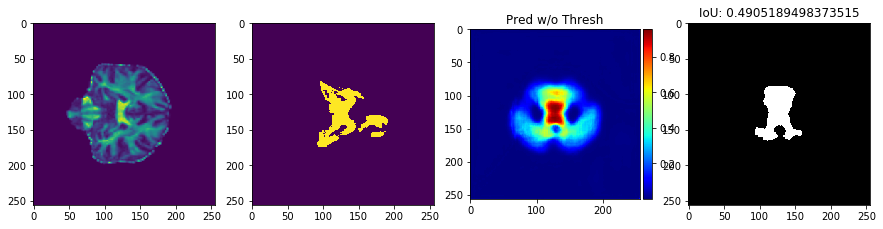

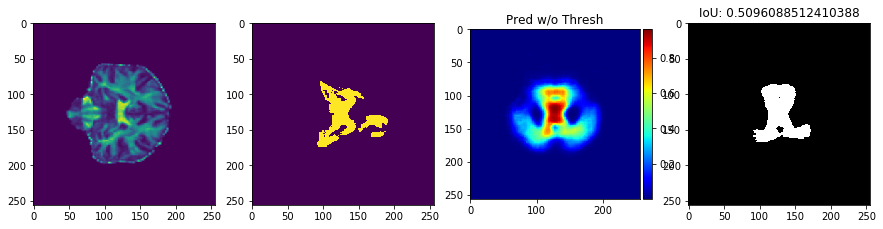

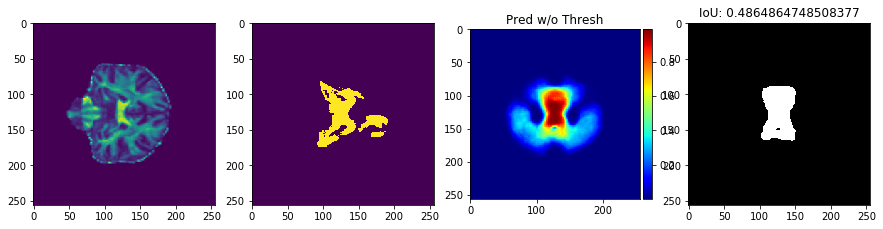

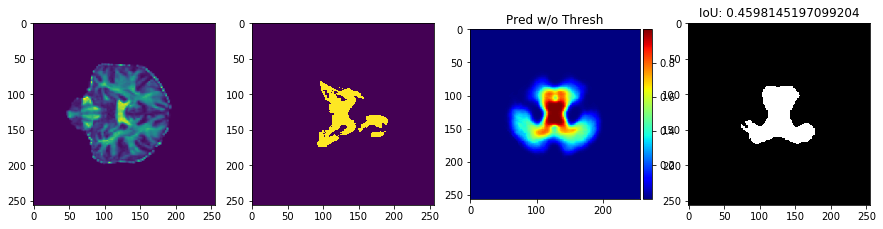

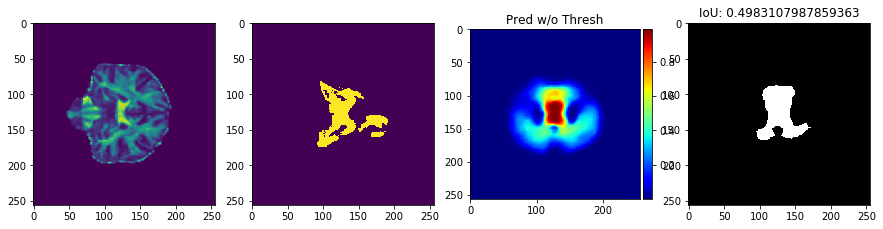

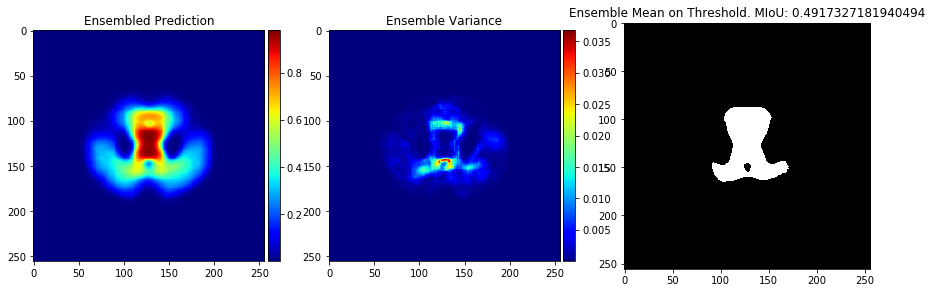

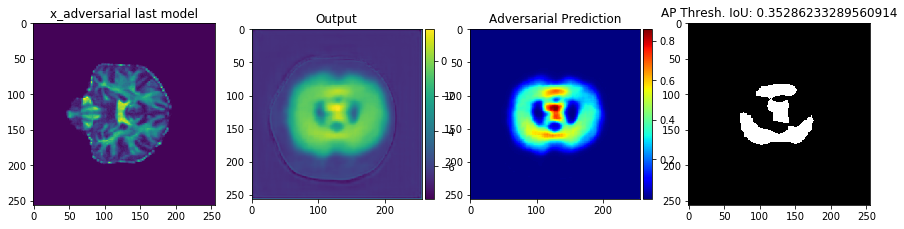

In [252]:
img_num = 133
threshold = 0.39
eps = 0.01
brain, x_adversarial = compute_ensemble_prediction(loaders, img_num, models, threshold, eps) #Takes a second to run if on CPU.
#thresh_prediction, ensemble_set, ensemble_pred, var, label, brain, predictions, output_adv, op_adv_probs, x_adversarial = compute_ensemble_prediction(loaders, img_num, models, threshold) #Takes a second to run if on CPU.

An ensemble is seen as a uniformly weighted gaussian mixture model (regression) and combine predictions
through a basic mean operation (segmentation).

We approximate the ensemble as a Gaussian who's mean and variance are respectively the mean and variance of the mixture. 

Mixture: $M^{-1} \sum{N(\mu_{\theta_m}(x), \sigma^2_{\theta_m}(x))} $
<br>
Mean: $\mu_{*}(x) = M^{-1} \sum{\mu_{\theta_m}(x)}$
<br>
Variance: $\sigma^2_{*}(x) = M^{-1}\sum{ (\sigma^2_{\theta_m}(x)+\mu^2_{\theta_m}(x)) - \mu^2_{*}(x)}$

In [230]:
threshed = ensemble_pred[0,0] > threshold
threshed = threshed.type(torch.FloatTensor)

overlap = threshed + label

Text(0.5, 1.0, 'Overlap of Ensemble Prediction + Label')

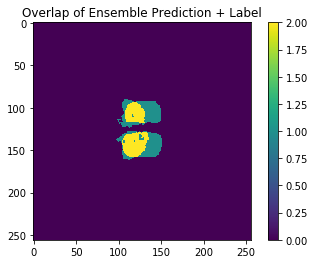

In [231]:
plt.imshow(overlap.detach().numpy())
plt.colorbar()
plt.title('Overlap of Ensemble Prediction + Label')

In [172]:
#This is the image that we're looking at. Need to remember that we're indexing randomly. 
loaders[0].dataset.images_fps[loaders[0].dataset.mapping[120]]

'/home/mccrinbc/Data_Removed_Useless_Slices/normalized_slices/FA_9103_norm_0094.tif'

In [212]:
x_adversarial

tensor([[[[ 0.0300,  0.0300, -0.0300,  ...,  0.0300, -0.0300,  0.0300],
          [ 0.0300,  0.0300, -0.0300,  ...,  0.0300, -0.0300,  0.0300],
          [ 0.0300,  0.0300, -0.0300,  ..., -0.0300, -0.0300, -0.0300],
          ...,
          [-0.0300,  0.0300,  0.0300,  ...,  0.0300,  0.0300, -0.0300],
          [-0.0300, -0.0300,  0.0300,  ..., -0.0300,  0.0300, -0.0300],
          [-0.0300,  0.0300,  0.0300,  ..., -0.0300,  0.0300, -0.0300]]]])

tensor(0.9383, grad_fn=<MaxBackward1>)

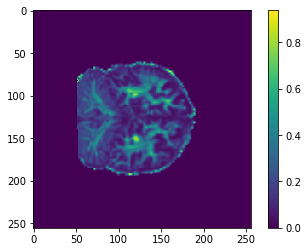

In [227]:
plt.imshow(brain[0][0].detach().numpy())
plt.colorbar()

In [82]:
a = models[0].eval()
a

Unet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [204]:
var = var / torch.max(var).item()

In [244]:
1 - var

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.9999, 0.9998, 0.9995],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9999, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9999],
          [0.9996, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]]],
       grad_fn=<RsubBackward1>)

In [84]:
x_grad = torch.sign(brain.grad.data)

AttributeError: 'NoneType' object has no attribute 'data'

In [156]:
means = sum(ensemble_set) / len(ensemble_set)
print(means)

tensor([[[[0.0668, 0.0264, 0.0226,  ..., 0.0198, 0.0194, 0.0634],
          [0.0362, 0.0089, 0.0085,  ..., 0.0089, 0.0054, 0.0224],
          [0.0229, 0.0052, 0.0046,  ..., 0.0062, 0.0044, 0.0207],
          ...,
          [0.0259, 0.0044, 0.0046,  ..., 0.0043, 0.0052, 0.0398],
          [0.0296, 0.0053, 0.0056,  ..., 0.0045, 0.0058, 0.0515],
          [0.0989, 0.0243, 0.0192,  ..., 0.0155, 0.0265, 0.0866]]]],
       grad_fn=<DivBackward0>)
